# Data Preparation

In [1]:
from pandas import DataFrame
from datetime import datetime

In [2]:
class MVTSSample:
    
    def __init__(self, active_region:str, flare_class:str, flare_type:str, \
                 verification:str, start_time:datetime, end_time:datetime, data:DataFrame):
        self.flare_type = flare_type
        self.active_region = active_region
        self.flare_class = flare_class
        self.verification = verification
        self.start_time = start_time
        self.end_time = end_time
        self.data = data
    
    def get_flare_type(self):
        return self.flare_type
    
    def get_flare_class(self):
        return self.flare_class
    
    def get_active_region(self):
        return self.active_region
    
    def get_verification(self):
        return self.verification
    
    def get_start_time(self):
        return self.start_time
    
    def get_end_time(self):
        return self.end_time
    
    def get_data(self):
        return self.data

In [3]:
import os
import pandas as pd

In [4]:
def read_mvts_instance(data_dir:str, file_name:str) -> MVTSSample: #Finished!
    # Get flare type from file name
    if file_name[0:1] == 'F' :
        flare_type = file_name[0:2]
    else:
        flare_type = file_name[0:4]
    active_region = file_name[file_name.find('_ar')+3: file_name.find('_s2')]
    
    verification = 'FQ'
    flare_class = 'FQ'
    if file_name[0:1] != 'F' :
        verification = file_name.split(':')[1].split('_')[0]
        flare_class = file_name[0:1]
    

    try:
        # Get start time from file name
        start = file_name.find('s2')
        start_time = file_name[start+1: start+20]
        start_time = start_time.replace("T", " ")
        start_time = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")

        # Get end time from file name
        end = file_name.find('e2')
        end_time = file_name[end+1: end+20]
        end_time = end_time.replace("T", " ")
        end_time = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        print(ValueError)
        pass

    # Get data from csv file
    try:
        data = pd.read_csv(data_dir + "/" + file_name, sep="\t")
        data['Timestamp'] = data['Timestamp'].str.replace('-', '')
        data['Timestamp'] = data['Timestamp'].str.replace(' ', '')
        data['Timestamp'] = data['Timestamp'].str.replace(':', '')
    except ValueError:
        print(ValueError)
        pass
    
    # Make mvts object 
    mvts = MVTSSample(active_region, flare_class, flare_type, verification, start_time, end_time, data)
    return mvts

In [5]:
import numpy as np

In [6]:
from os import listdir

In [7]:
import csv
import numpy as np
import pickle
from tqdm import tqdm


def process_partition(partition_location:str, data_dir_save:str, abt_name:str):
    abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']
    
    abt_header_label = ['FLARE_CLASS', 'FLARE_TYPE', 'ACTIVE_REGION', 'VERIFICATION']
    
    abt_label = pd.DataFrame(columns=abt_header_label)
    

    # Get lists of data from partition
    FL = os.listdir(partition_location + "/FL")
    NF = os.listdir(partition_location + "/NF")
    
    number_of_features=25
    number_of_timestamps=60
    abt = np.zeros((number_of_timestamps,number_of_features,len(FL + NF)))
    
    count = 0
    # Add row to abt from mvssample object and its median and std data
    with tqdm(len(FL + NF)) as pbar:

        for d in FL + NF:

            # Use temp list for each row and temp df
            list2add_label = []
            tempdf = pd.DataFrame(columns=abt_header)
            tempdf_label = pd.DataFrame(columns=abt_header_label)

            # Get mvs object and add flare type 
            if d in FL:
                mvs = read_mvts_instance(partition_location + '/FL', d)
            else:
                mvs = read_mvts_instance(partition_location + '/NF', d)
            list2add_label.append(mvs.get_flare_class())
            list2add_label.append(mvs.get_flare_type())
            list2add_label.append(mvs.get_active_region())
            list2add_label.append(mvs.get_verification())


            # Set up temp df for future concat with master data frame object
            templist = mvs.get_data()[abt_header]
            templist = templist.to_numpy()

            # From data frame concat current with temp for each feature 
            abt[:,:,count] = templist

            tempdf_label.loc[len(abt_header_label)] = list2add_label
            abt_label = pd.concat([abt_label, tempdf_label], ignore_index= True, axis = 0)


            count +=1
            pbar.update(1)
            #if count >= 1000:
                #break
            #continue
            

    print(abt_name)        
    print("shape: " + str(abt.shape))
    with open(data_dir_save + "raw/" + abt_name + ".pkl", 'wb') as f:
        pickle.dump(abt, f)
        
    abt_label.to_csv(data_dir_save + "labels/" + abt_name + "_labels.csv", index=False, header=True)
    # return the completed analitics base table
    return abt_label

# Data Exploration

In [9]:

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/Data"  
data_dir_save = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/"  

# change the path to where your data is stored.


for i in range(1,6):
    abt_name = "partition" + str(i) # Corrected to partition 1
    abt = process_partition(data_dir + "/" + "partition" + str(i), data_dir_save, abt_name)
    print("number of instances: " + str(abt.shape[0]))
    print(abt.head(5))
    print('\n')

73492it [03:33, 344.18it/s]


partition1
shape: (60, 25, 73492)
number of instances: 73492
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.0           115      Primary
1           M       M2.0            54      Primary
2           M       M1.3           384      Primary
3           M       M3.5           753      Primary
4           M       M1.0           437      Primary




88557it [04:37, 319.16it/s]


partition2
shape: (60, 25, 88557)
number of instances: 88557
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M5.7          1638      Primary
1           M       M2.8          1461      Primary
2           M       M1.0          1603      Primary
3           M       M5.7          1638      Primary
4           M       M1.9          1621      Primary




42510it [01:55, 369.16it/s]


partition3
shape: (60, 25, 42510)
number of instances: 42510
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.6          3497      Primary
1           M       M1.0          3688    Secondary
2           M       M1.3          4186      Primary
3           M       M2.5          3341      Primary
4           M       M2.3          3721      Primary




51261it [02:22, 359.48it/s]


partition4
shape: (60, 25, 51261)
number of instances: 51261
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M1.3          4874      Primary
1           X       X1.6          4781      Primary
2           M       M1.6          4920      Primary
3           M       M1.2          4344      Primary
4           M       M1.4          4294      Primary




75365it [03:40, 342.48it/s]


partition5
shape: (60, 25, 75365)
number of instances: 75365
  FLARE_CLASS FLARE_TYPE ACTIVE_REGION VERIFICATION
0           M       M6.5          5692      Primary
1           M       M5.5          5983      Primary
2           M       M1.0          6327      Primary
3           M       M1.0          5885      Primary
4           M       M1.1          6015      Primary




# Class Distribution

In [12]:
import pandas as pd
labels = []
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/labels/"

for i in range(1,6):
    labels.append(pd.read_csv(data_dir + "partition" + str(i) + "_labels.csv"))

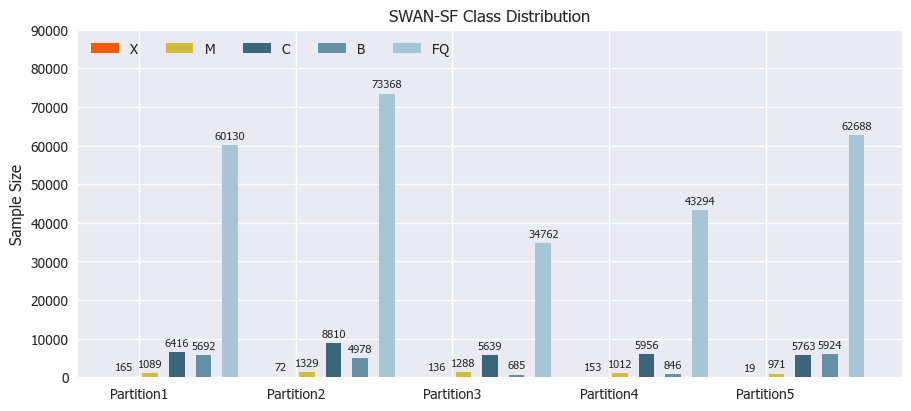

In [16]:
# Create dictionary for counts of each flare type
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

flare_types = {"X": [0,0,0,0,0], "M": [0,0,0,0,0], "C": [0,0,0,0,0], "B": [0,0,0,0,0], "FQ": [0,0,0,0,0]}
color = ['#f95a00','#d1bc3f','#3b657b','#6590a6','#a6c5d5']
plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

    
for i in range(1,6):

    # For each objects flare type sort into M, X, C, B, or FQ, otherwise skip
    for j in labels[i-1]['FLARE_TYPE']:
        if "M" in j:
            flare_types["M"][i-1] +=1
        elif "X" in j:
            flare_types["X"][i-1] +=1
        elif "C" in j:
            flare_types["C"][i-1] +=1
        elif "B" in j:
            flare_types["B"][i-1] +=1
        elif "FQ" in j:
            flare_types["FQ"][i-1] +=1
        else:
            continue


group = ("Partition1", "Partition2", "Partition3", "Partition4", "Partition5")

x = np.arange(len(group))  # the label locations
width = 0.10  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', sharey=True,
  figsize=(9, 4))

for attribute, measurement in flare_types.items():
    offset = width * multiplier * 1.7
    rects = ax.bar(x + offset, measurement, width, label=attribute, color = color[multiplier] )
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sample Size')
ax.set_title('SWAN-SF Class Distribution')
ax.set_xticks(x + width, group)
ax.legend(loc='upper left', ncols=5)
ax.set_ylim(0, 90000)

plt.show()

# Missing value Exploration

In [17]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/raw/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [18]:
abt_header = ['Timestamp', 'R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

null_count = [0,0,0,0,0]
non_null_count = [0,0,0,0,0]
null_count_per_feature = np.zeros((5,125), dtype=int)

for i in range(1,6):
    partition = np.array(data[i-1])
    
    for j in range(1,partition.shape[2]):
        mvts = partition[:,:, j-1]
        for m in range(1,26):
            for n in range (1,61):
                if (mvts[n-1,m-1] == 0.0):
                    null_count[i-1] += 1
                    null_count_per_feature[i-1,m-1] += 1
                else:
                    non_null_count[i-1] += 1
    
    print("Partition" + str(i) + ":")
    print("null counts in P" + str(i) + ": " + str(null_count[i-1]))
    print("non-null counts in P"+ str(i) + ": " + str(non_null_count[i-1]))
    for x in range(1,26):
        print(abt_header[x-1] + ": " + str(null_count_per_feature[i-1,x-1]))
    
    print("\n")

Partition1:
null counts in P1: 2487130
non-null counts in P1: 107749370
Timestamp: 0
R_VALUE: 2399204
TOTUSJH: 652
TOTBSQ: 652
TOTPOT: 652
TOTUSJZ: 652
ABSNJZH: 652
SAVNCPP: 652
USFLUX: 652
TOTFZ: 652
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 81406
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 652
MEANJZD: 0
MEANALP: 0
TOTFX: 652


Partition2:
null counts in P2: 4002443
non-null counts in P2: 128831557
Timestamp: 0
R_VALUE: 2934858
TOTUSJH: 93300
TOTBSQ: 93300
TOTPOT: 93300
TOTUSJZ: 93300
ABSNJZH: 93300
SAVNCPP: 93300
USFLUX: 93300
TOTFZ: 93300
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0
SHRGT45: 134585
MEANGAM: 0
MEANGBT: 0
MEANGBZ: 0
MEANGBH: 0
MEANJZH: 0
TOTFY: 93300
MEANJZD: 0
MEANALP: 0
TOTFX: 93300


Partition3:
null counts in P3: 1472336
non-null counts in P3: 62291164
Timestamp: 0
R_VALUE: 1361036
TOTUSJH: 2718
TOTBSQ: 2718
TOTPOT: 2718
TOTUSJZ: 2718
ABSNJZH: 2718
SAVNCPP: 2725
USFLUX: 2718
TOTFZ: 2718
MEANPOT: 0
EPSX: 0
EPSY: 0
EPSZ: 0
MEANSHR: 0

# MVTS visualization

In [19]:
sample_flare_index = [0,0,0,0,0]

for i in range(0,len(labels[0]['FLARE_CLASS'])):
    if labels[0]['FLARE_CLASS'][i] == 'X':
        sample_flare_index[0] = i
    elif labels[0]['FLARE_CLASS'][i] == 'M':
        sample_flare_index[1] = i
    elif labels[0]['FLARE_CLASS'][i] == 'C':
        sample_flare_index[2] = i
    elif labels[0]['FLARE_CLASS'][i] == 'B':
        sample_flare_index[3] = i
    elif labels[0]['FLARE_CLASS'][i] == 'FQ':
        sample_flare_index[4] = i
    
    count = 0
    for j in range(0,5):
        if sample_flare_index[j] != 0:
            count += 1
    if count == 5:
        break
       

In [20]:
from scipy.stats import zscore
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)

color = ['#f95a00','#d1bc3f','#3b657b','#6590a6','#a6c5d5']
label = ['X', 'M', 'C', 'B', 'FQ']

def plot_time_series_class(data, class_name, ax, n_steps=10):
    
    time_series_df = pd.DataFrame(data)
    
    for i in range(0,5):
        
        temp = time_series_df[i].to_numpy()
        new_2d = temp.reshape(len(time_series_df[i]), 1)
        new_1d = imputer.fit_transform(new_2d)[:,0]
        time_series_df[i] = zscore(pd.DataFrame(new_1d))
        
    
        smooth_path = time_series_df[i].rolling(n_steps).mean()
        ax.plot(smooth_path, linestyle='-', linewidth=1, label=label[i], color=color[i])
    

    ax.set_ylabel(class_name)
    ax.legend();

Class: X
Start Time: 2011-03-09 01:36  and  End Time: 2011-03-09 13:24
Class: M
Start Time: 2011-10-01 09:36  and  End Time: 2011-10-01 21:24
Class: C
Start Time: 2011-08-03 07:12  and  End Time: 2011-08-03 19:00
Class: B
Start Time: 2011-04-24 15:12  and  End Time: 2011-04-25 03:00
Class: FQ
Start Time: 2011-11-02 19:48  and  End Time: 2011-11-03 07:36


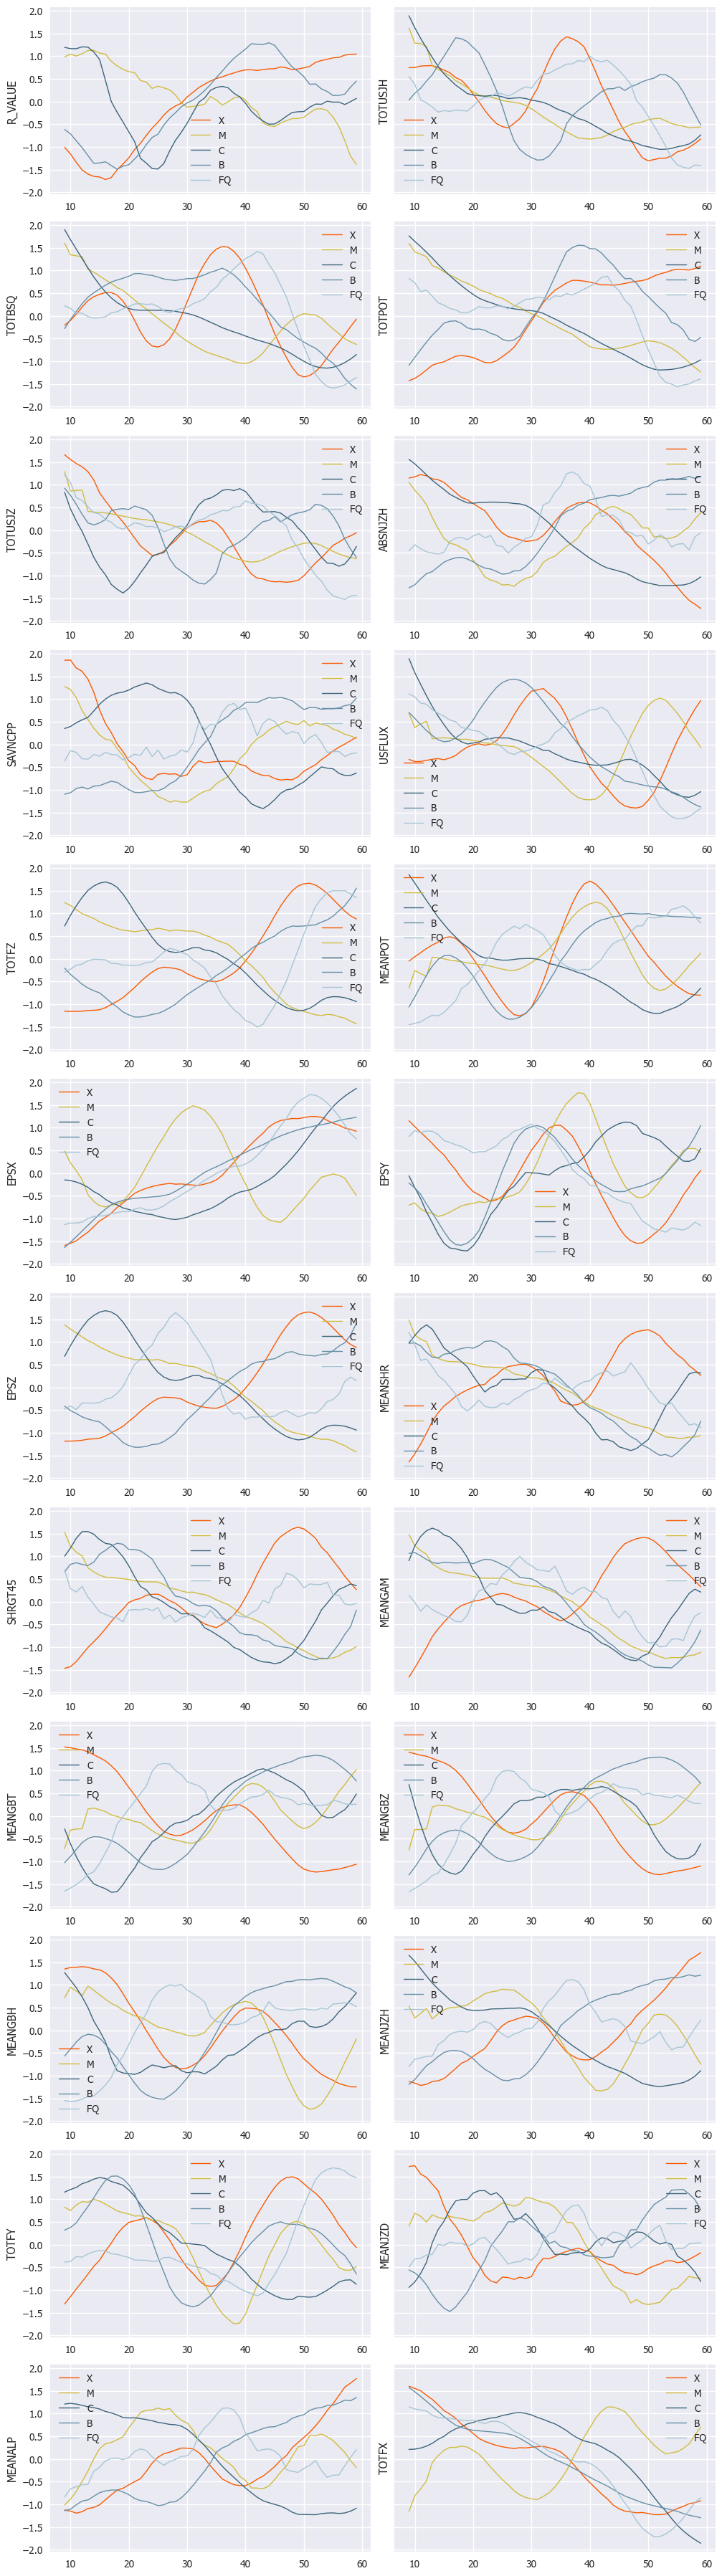

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

abt_header = ['R_VALUE','TOTUSJH','TOTBSQ','TOTPOT','TOTUSJZ','ABSNJZH','SAVNCPP',
                           'USFLUX','TOTFZ','MEANPOT', 'EPSX', 'EPSY','EPSZ','MEANSHR','SHRGT45','MEANGAM',
                              'MEANGBT','MEANGBZ','MEANGBH','MEANJZH','TOTFY','MEANJZD','MEANALP','TOTFX']

fig, axs = plt.subplots(12,2, sharey=True,
  figsize=(10, 36))

sample_flare_mvts = np.zeros((60,25,5))

for i in range(0,5):
    sample_flare_mvts[:,:, i] = data[0][:,:, sample_flare_index[i]]
    
    timestamp = sample_flare_mvts[:,0, i]

    start_time = str(timestamp[0])[0:4] + '-' + str(timestamp[0])[4:6] + '-' + str(timestamp[0])[6:8] \
                + ' ' + str(timestamp[0])[8:10] + ":" + str(timestamp[0])[10:12]

    end_time = str(timestamp[59])[0:4] + '-' + str(timestamp[59])[4:6] + '-' + str(timestamp[59])[6:8] \
                + ' ' + str(timestamp[59])[8:10] + ":" + str(timestamp[59])[10:12]

    if i == 0:
        print('Class: X') 
    elif i == 1:
        print('Class: M') 
    elif i == 2:
        print('Class: C') 
    elif i == 3:
        print('Class: B') 
    else:
        print('Class: FQ') 
        
    print('Start Time: ' + start_time + '  and  End Time: ' + end_time)


for i, cls in enumerate(abt_header):
    ax = axs.flat[i]
    data = sample_flare_mvts[:,i+1,:]
    
    plot_time_series_class(data, cls, ax)

fig.tight_layout();
    

# KNN Imputation 

In [31]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/raw/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [32]:
# Inter Column and Between Instance Imputation

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed/"

from tqdm import tqdm

k = 100
number_of_partitions = 2 #5
for i in range(0,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = np.array(data[i])[:,:,j]
            for m in range(0,24):
                new_column[:,m+1][new_column[:,m+1] == 0] = np.nan
                
                if np.isnan(new_column[:,m+1]).all():
                    for n in range(1, k+1):
                        if np.isnan(new_partition[:,m+1,j-n]).all() == False:
                            new_column[:,m+1] = new_partition[:,m+1,j-n]
                            break
                else:
                    new_2d = new_column[:,m+1].reshape(len(new_column[:,m+1]), 1)
                    new_column[:,m+1] = imputer.fit_transform(new_2d)[:,0]
                 
                
                
                        
                
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)
            
            
# Between Instance Imputation

73492it [2:01:47, 10.06it/s]
7399it [14:13,  8.67it/s]


KeyboardInterrupt: 

# Z Normalization (Column)

In [ ]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + "_imputed" + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [10]:
# Column by Column

from scipy.stats import zscore
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed_zscore_c/"

for i in range(0,5):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = np.array(data[i])[:,:,j]
            for m in range(0,24):
                new_column[:,m+1] = zscore(new_column[:,m+1])
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed_ZScoreColumn" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

        
                   

3it [00:00, 10.46it/s]

[2.01008070e+13 2.01008070e+13 2.01008070e+13 2.01008070e+13
 2.01008070e+13 2.01008070e+13 2.01008070e+13 2.01008070e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008071e+13 2.01008071e+13 2.01008071e+13
 2.01008071e+13 2.01008072e+13 2.01008072e+13 2.01008072e+13]
[ 1.00995061  0.86296056  1.28014453  1.29556192  1.45052985  0.93104256
 -0.1145919

5it [00:00, 11.15it/s]

[2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108072e+13 2.01108072e+13
 2.01108072e+13 2.01108072e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13
 2.01108080e+13 2.01108080e+13 2.01108080e+13 2.01108080e+13]
[ 0.31700804  1.42124104  1.93407876  2.06334409  2.45237765  2.18305329
  0.4046202

8it [00:00, 10.03it/s]

[2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203051e+13 2.01203051e+13 2.01203051e+13
 2.01203051e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13
 2.01203052e+13 2.01203052e+13 2.01203052e+13 2.01203052e+13]
[ 1.53670122  1.57839273  1.46808285  1.81825177  1.71575793  1.66792763
  1.5852770

KeyboardInterrupt: 

# Z Normalization (Flattened)

In [ ]:
# Flattened

from scipy.stats import zscore
from tqdm import tqdm

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed_zscore_f/"

for i in range(0,5):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            flattened = np.zeros((1440))  
            flattened = np.array(data[i])[:,:,j].flatten()[60:1500]
            flattened = zscore(flattened)
            new_column = np.zeros((60,25))  
            new_column[:,0] = np.array(data[i])[:,0,j]
            for m in range(1,25):
                new_column[:,m] = flattened[(m-1)*60:m*60]
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed_ZScoreFlattened" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

# Max Min Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/minmaxscalar/"

from tqdm import tqdm

number_of_partitions = 2 #5

for i in range(0,number_of_partitions):
    new_partition = np.zeros((60,25,np.array(data[i]).shape[2]))
    new_partition = np.array(data[i])
    
    with tqdm(np.array(data[i]).shape[2]) as pbar:
        for j in range(0,np.array(data[i]).shape[2]):
            new_column = np.zeros((60,25))  
            new_column = np.array(data[i])[:,:,j]
            for m in range(0,24):
                new_column[:,m+1] = scaler.fit_transform(new_column[:,m+1])
                
            new_partition[:,:,j] = new_column

            pbar.update(1)

        with open(data_dir + "partition" + str(i+1) + "_imputed_MinMaxScaler" + ".pkl", 'wb') as f:
            pickle.dump(new_partition, f)

# Building AR Data

# Train Test Split

(1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5), (3,4), (3,5), (4,5)

In [ ]:
import pickle
import numpy as np

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/imputed_minmaxscalar/"
data = []

for i in range(1,6):
# Load the array with Pickle
    with open(data_dir + "partition" + str(i) + "_imputed_MinMaxScaler" + ".pkl", 'rb') as f:
        data.append(pickle.load(f))

In [ ]:
train_number = 0 # 0 to 4
test_number = 1 # 0 to 4
# test_number should be bigger than train_number

xTrain = data[train_number]
yTrain = labels[train_number]

xTest = data[test_number]
yTest = labels[test_number]

# First round ML

ROCKET, LSTM, GRU, RNN, TSF (1D-CNN)

In [ ]:
# ROCKET
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
X_train = scalar.fit_transform(data[0])



rocket_pipeline = make_pipeline(
    Rocket(), SGDClassifier(max_iter=1000, tol=1e-3))

rocket_pipeline.fit(X_train, y_train)

rocket_pipeline.score(X_test, y_test)

In [ ]:
# LSTM
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

# Undersampling and Oversampling

SMOTE, ADASYN, TimeGAN, Noise Injection | RUS and Tomek Links

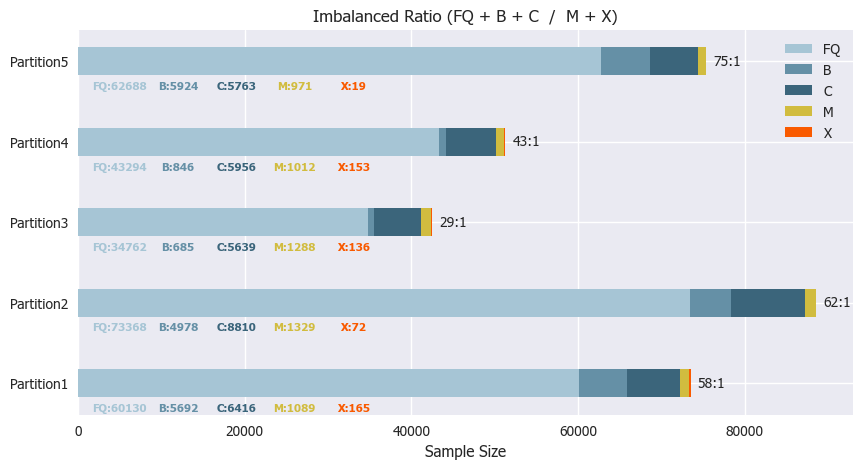

In [209]:
flare_types = {"FQ": [0,0,0,0,0], "B": [0,0,0,0,0], "C": [0,0,0,0,0], "M": [0,0,0,0,0], "X": [0,0,0,0,0]}
imbalanced = {1: [0,0], 2: [0,0], 3: [0,0], 4: [0,0], 5: [0,0]}

plt.style.use('seaborn-v0_8')


font = {'family' : 'Tahoma',
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

color = ['#a6c5d5','#6590a6','#3b657b','#d1bc3f','#f95a00']
group = ["Partition1", "Partition2", "Partition3", "Partition4", "Partition5"]

    
for i in range(1,6):

    # For each objects flare type sort into M, X, C, B, or FQ, otherwise skip
    for j in labels[i-1]['FLARE_TYPE']:
        if "M" in j:
            flare_types["M"][i-1] +=1
            imbalanced[i][0] +=1
        elif "X" in j:
            flare_types["X"][i-1] +=1
            imbalanced[i][0] +=1
        elif "C" in j:
            flare_types["C"][i-1] +=1
            imbalanced[i][1] +=1
        elif "B" in j:
            flare_types["B"][i-1] +=1
            imbalanced[i][1] +=1
        elif "FQ" in j:
            flare_types["FQ"][i-1] +=1
            imbalanced[i][1] +=1
        else:
            continue

            
fig, ax = plt.subplots(sharey=True,
  figsize=(10, 5))

left = np.zeros(len(flare_types.keys()))

for i, col in enumerate(flare_types.keys()):
    ax.barh(
        group, flare_types[col], height=0.35, left=left, label=col, color=color[i])
    left += np.array(flare_types[col])
    
    

totals = [0,0,0,0,0]
for i in range(0,5):
    totals[i] = flare_types['FQ'][i] + flare_types['B'][i] + flare_types['C'][i] + flare_types['M'][i] + \
    flare_types['X'][i]
    
y_offset = 2500
x_offset = - 0.05
for i, total in enumerate(totals):
    ax.text(total + y_offset, i + x_offset, str(str(round(imbalanced[i+1][1] / imbalanced[i+1][0]))+":1"),
            ha='center', weight='normal', size=10)

# Let's put the annotations inside the bars themselves by using a
# negative offset.
x_offset = -0.35
y_offset = -2000
# For each patch (basically each rectangle within the bar), add a label.

# For each patch (basically each rectangle within the bar), add a label.
count = 0
color_number = 0
for bar in ax.patches:
    if count == 5:
        color_number += 1
        count = 0
    count += 1
        
    ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      5000 + color_number * 7000,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_y() + bar.get_height() / 2 + x_offset,
      # This is actual value we'll show.
      list(flare_types.keys())[color_number] + ':' + str(int(bar.get_width())),
      # Center the labels and style them a bit.
      ha='center',
      color=color[color_number],
      weight='bold',
      size=8
  )

ax.set_title("Imbalanced Ratio (FQ + B + C  /  M + X)")
ax.set_xlabel('Sample Size')
    
ax.legend()

In [94]:
# SMOTE and RUS

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

In [ ]:
# ADASYN and RUS
from imblearn.over_sampling import ADASYN 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = ADASYN(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)

# Second round ML

ROCKET, LSTM, GRU, RNN, TSF (On Augmented data)

In [ ]:
# ROCKET (SMOTE and RUS)


In [ ]:
# ROCKET (ADASYN and RUS)

In [ ]:
# LSTM (SMOTE and RUS)

In [ ]:
# LSTM (ADASYN and RUS)

# Comparison

# Final Visualizations